In [ ]:
! pip install kaggle  
! mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c dog-breed-identification
! unzip dog-breed-identification.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: train/83fad0718581a696132c96c166472627.jpg  
  inflating: train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: train/840db91ba4600148f3dcb06ec419b421.jpg  
  inflating: train/840dbad5a691c22611d85b2488bf4cbb.jpg  
  inflating: train/8410ced9ebc1759a7ebce5c42bfb5222.

# I. Librairies Utilisee

In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm

# II. Exploration de données brutes

---
***L'objectif de l'exploration des donnees est de clarifier nos donnees et comprendre les relations entre eux ainsi que la detection des problemes potentiel afin de l'eviter dans la partie du PreProcessing.***



 ---
 **Notre dataset initial se compose de 4 fichiers:**
 
   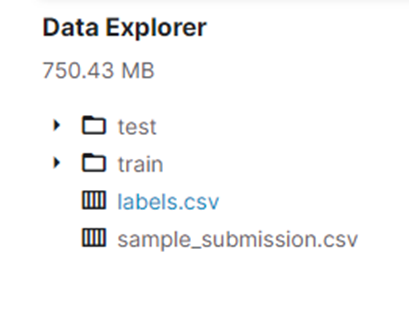
     
   > **train**: un dossier contient 10222 images (le nom = id et l'extension =jpg )
    
   > **labesl.csv** : un fichier excel composee de deux 2 colonnes(id & breed) et 10222 lignes, chaque id d'image du fichier "train" avec sa race (breed), comprend 120 races de chiens
    
   > **test** : un dossier contient 10375 images  (le nom = id et l'extension =jpg )
   
---
    

### **A. Exploration du fichier Label.csv**

In [2]:
lab = pd.read_csv("dog_breed_identification/labels.csv")
lab.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


---

In [3]:
lab["breed"].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64


**on a 120 races en total et chaque race contient peu d'images le max 126 et le min 66**

**On observe que le nombre des classes est tres grands, 120 classes, On doit penser a un fusionnement des classes.**

--- 

---
### **B. Exploration des images** (dossier train et test)

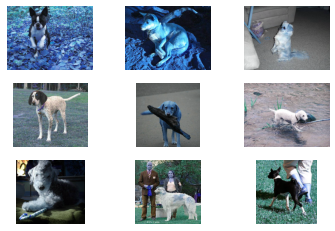

In [6]:
import cv2
import glob
import matplotlib.pyplot as plt

path="dog_breed_identification/train/*.jpg"

images=[cv2.imread(image) for image in glob.glob(path)[:9]]
fig=plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i])
    plt.axis("off")
plt.show()

On voit que les images sont de dimensions different et qualite different, ce qui pevent affecter la qualite d'entrainement de notre modele.

Tous ces problemes qui seront addressee dans la partie PreProcessing des donnees.


---



---



In [7]:
import os
print("Nombre totals des images est : ",len(os.listdir("dog_breed_identification/train/")))

Nombre totals des images est :  10222


       

---



In [8]:
import cv2
import os
i=0
im=0
for img in os.listdir("dog_breed_identification/train/"):
    i+=1
        
    im = cv2.imread("dog_breed_identification/train/"+img)
    print(im.shape)
    
    if i ==10:
        break

(375, 500, 3)
(375, 500, 3)
(375, 500, 3)
(344, 400, 3)
(500, 500, 3)
(375, 500, 3)
(470, 500, 3)
(227, 231, 3)
(500, 474, 3)
(332, 500, 3)



***On voit que les dimensions des images sont different l'un par rapport a l'autre, donc le redimensionnement (Resizing) des images doit etre inclus dans notre traitement afin d'unifier les dimensions des images.***

---

In [9]:
from PIL import Image
import os
filenames = os.listdir("dog_breed_identification/train")
min(Image.open("dog_breed_identification/train/"+f, 'r').size for f in filenames)

(97, 134)



 **On voit que la taille minimale d'une image dans toutes la dataset est de : (97,134), on choisit une dimension convenable. dans notre cas, on choisirera (150,150)**
 
---

# III. Traitement des donnees.

### **A. Organisation des images par classes.**

Le premier probleme qu'on doit adresser dans notre traitement, est la mal structuration et organisation des donnees.

Tous les images sont dans le dossier train sont aucune classification initial.



> 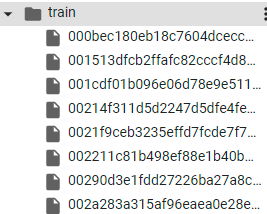



**Notre objectif, est de grouper les images qui appartient a la meme classes dans un dossier avec le nom de cette classe,
tous ces dossier seront dans le dossier train.**



On se base sur la librarie **shutil** pour faire ces manipulations.

In [ ]:
import shutil

for index, row in lab.iterrows():
    if not os.path.exists("dog_breed_identification/dataset_breed/"+row['breed']):
        os.makedirs("dog_breed_identification/dataset_breed/"+row['breed'])
       
    if os.path.exists("dog_breed_identification/train/"+row['id']+".jpg"):
        shutil.copy2("dog_breed_identification/train/"+row['id']+".jpg","dog_breed_identification/dataset_breed/"+row['breed'])

**Donnees apres Organisation:**


> 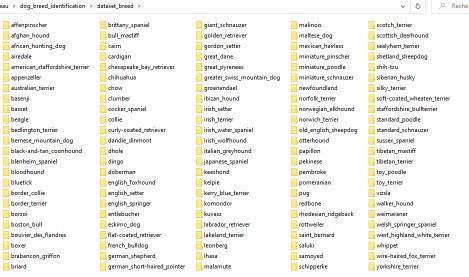






---



In [10]:
import os
cpt = sum([len(files) for r, d, files in os.walk("dog_breed_identification/dataset_breed")])
print(cpt)

10222


In [11]:
import os

for breed in os.listdir("dog_breed_identification/dataset_breed/"):
    i=0
    for img in os.listdir("dog_breed_identification/dataset_breed/"+breed):
        i+=1
    print(breed+ " : ")    
    print( i)    

affenpinscher : 
80
afghan_hound : 
116
african_hunting_dog : 
86
airedale : 
107
american_staffordshire_terrier : 
74
appenzeller : 
78
australian_terrier : 
102
basenji : 
110
basset : 
82
beagle : 
105
bedlington_terrier : 
89
bernese_mountain_dog : 
114
black-and-tan_coonhound : 
77
blenheim_spaniel : 
102
bloodhound : 
85
bluetick : 
85
border_collie : 
72
border_terrier : 
91
borzoi : 
75
boston_bull : 
87
bouvier_des_flandres : 
86
boxer : 
75
brabancon_griffon : 
67
briard : 
66
brittany_spaniel : 
73
bull_mastiff : 
75
cairn : 
106
cardigan : 
76
chesapeake_bay_retriever : 
83
chihuahua : 
71
chow : 
93
clumber : 
80
cocker_spaniel : 
74
collie : 
87
curly-coated_retriever : 
72
dandie_dinmont : 
89
dhole : 
76
dingo : 
80
doberman : 
74
english_foxhound : 
86
english_setter : 
83
english_springer : 
75
entlebucher : 
115
eskimo_dog : 
66
flat-coated_retriever : 
72
french_bulldog : 
70
german_shepherd : 
69
german_short-haired_pointer : 
75
giant_schnauzer : 
69
golden_retrie

Alors on remarque qu'on a beaucoup de classes (breed), plus exactement 120 classes, et le nombre des images dedans est petit.



> Donc on pense a faire un **merge**, d'une autre facon combiner les classes ayant une similarite entre eux dans une classe mere.




---



### **B. Organiser les classes similaires en une seul classe mere**


L'objectif de cette partie, est de remplacer tous les races qui sont similiares ou herite d'une race mere, par la race (classe) mere.

>Cela va reduire l'immense nombre des classes qu'on et va simplifier notre entrainement.

In [ ]:
for breed in os.listdir("dog_breed_identification/dataset_breed/"): #Pour toutes classe des chiens
    
    #Classes des chiens similaires
    if breed in ['walker_hound','afghan_hound', 'american_english_coonhound', 'american_foxhound', 'azawakh', 'basenji', 'basset_hound', 'beagle', 'black-and-tan_coonhound', 'bloodhound', 'bluetick', 'borzoi', 'cirneco_dell’etna', 'dachshund', 'english_foxhound', 'grand_basset_griffon_vendeen', 'greyhound', 'harrier', 'ibizan_hound', 'irish_wolfhound', 'norwegian_elkhound', 'otterhound', 'petit_basset_griffon_vendeen', 'pharaoh_hound', 'plott_hound', 'portuguese_podengo_pequeno', 'redbone', 'rhodesian_ridgeback', 'saluki', 'scottish_deerhound', 'sloughi', 'treeing_walker_coonhound', 'whippet'] :
        
        if not os.path.exists("newDataset/Hound Group"):
                os.makedirs("newDataset/Hound Group")
        for image in os.listdir("dog_breed_identification/dataset_breed/"+breed):
             shutil.copy2("dog_breed_identification/dataset_breed/"+breed+"/"+image,"newDataset/Hound Group/")
             

    if breed in ['groenendael','australian_cattle_dog', 'australian_shepherd', 'bearded_collie', 'beauceron', 'belgian_laekenois', 'malinois', 'belgian_sheepdog', 'belgian_tervuren', 'bergamasco', 'berger_picard', 'border_collie', 'bouvier_des_flandres', 'briard', 'canaan_dog', 'cardigan', 'collie', 'entlebucher', 'finnish_lapphund', 'german_shepherd', 'icelandic_sheepdog', 'miniature_american_shepherd', 'norwegian_buhund', 'old_english_sheepdog', 'pembroke', 'polish_lowland_sheepdog', 'puli', 'pumi', 'pyrenean_shepherd', 'shetland_sheepdog', 'spanish_water_dog', 'swedish_vallhund']:
        if not os.path.exists("newDataset/Herding Group"):
            
            os.makedirs("newDataset/Herding Group")
        for image in os.listdir("dog_breed_identification/dataset_breed/"+breed):
            shutil.copy2("dog_breed_identification/dataset_breed/"+breed+"/"+image,"newDataset/Herding Group/")
    

    if breed in ['japanese_spaniel','affenpinscher', 'brussels_griffon', 'cavalier_king_charles_spaniel', 'chihuahua', 'chinese_crested', 'english_toy_spaniel', 'havanese', 'italian_greyhound', 'japanese_chin', 'maltese', 'manchester_terrier', 'miniature_pinscher', 'papillon', 'pekinese', 'pomeranian', 'toy_poodle', 'pug', 'shih-tzu', 'silky_terrier', 'toy_fox_terrier', 'yorkshire_terrier']:
        if not os.path.exists("newDataset/Toy Group"):
            os.makedirs("newDataset/Toy Group")
        for image in os.listdir("dog_breed_identification/dataset_breed/"+breed):
            shutil.copy2("dog_breed_identification/dataset_breed/"+breed+"/"+image,"newDataset/Toy Group/")
    

    if breed in ['eskimo_dog', 'bichon_frise', 'boston_bull', 'bulldog', 'chinese_shar-pei', 'chow_chow', 'coton_de_tulear', 'dalmatian', 'finnish_spitz', 'french_bulldog', 'keeshond', 'lhasa', 'lowchen', 'norwegian_lundhund', 'poodle', 'schipperke', 'shiba_inu', 'tibetan_spaniel', 'tibetan_terrier', 'xoloitzcuintli']:
        if not os.path.exists("newDataset/Non-Sporting Group"):
            os.makedirs("newDataset/Non-Sporting Group")
        for image in os.listdir("dog_breed_identification/dataset_breed/"+breed):
            shutil.copy2("dog_breed_identification/dataset_breed/"+breed+"/"+image,"newDataset/Non-Sporting Group/")
    

    if breed in ['american_water_spaniel', 'barbet', 'boykin_spaniel', 'brittany', 'chesapeake_bay_retriever', 'clumber_spaniel', 'cocker_spaniel', 'curly-coated_retriever', 'english_cocker_spaniel', 'english_setter', 'english_springer_spaniel', 'field_spaniel', 'flat-coated_retriever', 'german_short-haired_pointer', 'german_wirehaired_pointer', 'golden_retriever', 'gordon_setter', 'irish_red_and_white_setter', 'irish_setter', 'irish_water_spaniel', 'labrador_retriever', 'lagotto_romagnolo', 'nederlandse_kooikerhondje', 'nova_scotia_duck_tolling_retriever', 'pointer', 'spinone_italiano', 'sussex_spaniel', 'vizsla', 'weimaraner', 'welsh_springer_spaniel', 'wirehaired_pointing_griffon', 'wirehaired_vizsla']:
        if not os.path.exists("newDataset/Sporting Group"):
            os.makedirs("newDataset/Sporting Group")
        for image in os.listdir("dog_breed_identification/dataset_breed/"+breed):
            shutil.copy2("dog_breed_identification/dataset_breed/"+breed+"/"+image,"newDataset/Sporting Group/")
        

    if breed in ['airedale', 'american_hairless_terrier', 'staffordshire_bullterrier', 'australian_terrier', 'bedlington_terrier', 'border_terrier', 'bull_terrier', 'cairn', 'cesky', 'dandie_dinmont', 'glen_of_imaal_terrier', 'irish_terrier', 'kerry_blue_terrier', 'lakeland_terrier', 'manchester_terrier', 'miniature_bull_terrier', 'miniature_schnauzer', 'norfolk_terrier', 'norwich_terrier', 'parson_russell_terrier', 'rat_terrier', 'russell_terrier', 'scotch_terrier', 'sealyham_terrier', 'skye_terrier', 'smooth_fox_terrier', 'soft-coated_wheaten_terrier', 'staffordshire_bull_terrier', 'welsh_terrier', 'west_highland_white_terrier', 'wire-haired_fox_terrier']:
        if not os.path.exists("newDataset/Terrier Group"):
            os.makedirs("newDataset/Terrier Group")
        for image in os.listdir("dog_breed_identification/dataset_breed/"+breed):
            shutil.copy2("dog_breed_identification/dataset_breed/"+breed+"/"+image,"newDataset/Terrier Group/")
    

    if breed in ['dhole','dingo','akita', 'malamute', 'anatolian_shepherd_dog', 'bernese_mountain_dog', 'black_russian_terrier', 'boerboel', 'boxer', 'bullmastiff', 'cane_corso', 'chinook', 'doberman', 'dogo_argentino', 'dogue_de_bordeaux', 'german_pinscher', 'giant_schnauzer', 'great_dane', 'great_pyrenees', 'greater_swiss_mountain_dog', 'komondor', 'kuvasz', 'leonberg', 'mastiff', 'neapolitan_mastiff', 'newfoundland', 'portuguese_water_dog', 'rottweiler', 'saint_bernard', 'samoyed', 'siberian_husky', 'standard_schnauzer', 'tibetan_mastiff']:
        if not os.path.exists("newDataset/Working Group"):
            os.makedirs("newDataset/Working Group")
        for image in os.listdir("dog_breed_identification/dataset_breed/"+breed):
            shutil.copy2("dog_breed_identification/dataset_breed/"+breed+"/"+image,"newDataset/Working Group/")
        

    if breed in ['belgian_laekenois', 'biewer_terrier', 'bracco_italiano', 'dutch_shepherd', 'lancashire_heeler', 'mudi', 'norrbottenspets', 'peruvian_inca_orchid', 'portuguese_podengo', 'russian_toy', 'teddy_roosevelt_terrier']:
        if not os.path.exists("newDataset/Miscellaneous Group"):
            os.makedirs("newDataset/Miscellaneous Group")
        for image in os.listdir("dog_breed_identification/dataset_breed/"+breed):
            shutil.copy2("dog_breed_identification/dataset_breed/"+breed+"/"+image,"newDataset/Miscellaneous Group/")
   

    if breed in ['mexican_hairless','american_bulldog', 'american_leopard_hound', 'appenzeller', 'kelpie', 'australian_stumpy_tail_cattle_dog', 'basset_fauve_de_bretagne', 'bavarian_mountain_scent_hound', 'bohemian_shepherd', 'bolognese', 'braque_de_bourbonnais', 'braque_francais_pyrenean', 'broholmer', 'carolina_dog', 'catahoula_leopard_dog', 'caucasian_shepherd_dog', 'central_asian_shepherd_dog', 'croatian_sheepdog', 'czechoslovakian_vlack', 'danish-swedish_farmdog', 'deutscher_wachtelhund_', 'drentsche_patrijshond', 'drever', 'estrela_mountain_dog', 'eurasier', 'french_spaniel', 'german_longhaired_pointer', 'german_spitz', 'hamiltonstovare', 'hanoverian_scenthound', 'hokkaido', 'hovawart', 'jagdterrier', 'jindo', 'kai_ken', 'karelian_bear_dog', 'kishu_ken', 'kromfohrlander', 'lapponian_herder', 'mountain_cur', 'perro_de_presa_canario', 'porcelaine', 'portuguese_pointer', 'portuguese_sheepdog', 'pudelpointer', 'pyrenean_mastiff', 'rafeiro_de_alentejo', 'romanian_mioritic_shepherd_dog', 'russian_tsvetnaya_bolonka', 'schapendoes', 'segugio_italiano', 'shikoku', 'slovakian_wirehaired_pointer', 'slovensky_cuvac', 'slovensky_kopov', 'small_musterlander_pointer', 'spanish_mastiff', 'stabyhoun', 'swedish_lapphund', 'taiwan_dog', 'thai_ridgeback', 'tornjak', 'tosa', 'transylvanian_hound', 'treeing_tennessee_brindle', 'wetterhoun', 'yakutian_laika'] :
        if not os.path.exists("newDataset/Foundation Stock Service"):
            os.makedirs("newDataset/Foundation Stock Service")
        for image in os.listdir("dog_breed_identification/dataset_breed/"+breed):
            shutil.copy2("dog_breed_identification/dataset_breed/"+breed+"/"+image,"newDataset/Foundation Stock Service/")
    

**Alors, on remarque que le nombre des classes a ete reduit, ce qui va simplifier l'apprenstissage du modele.**



> 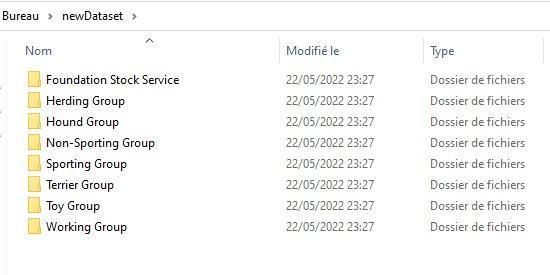



### **B.visualisation de nouvelle dataset**

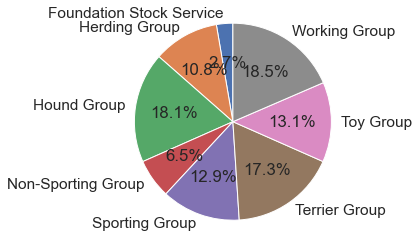

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import os


labels = os.listdir("newDataset")
sizes = []
for folder in labels:
  sizes.append(len(os.listdir("newDataset/"+folder)))

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',startangle=90)
ax1.axis('equal')  

plt.show()

### **C. Data augmentation - Oversampling**


> Apres visualisation du dataset final, on voit que les donnees sont tres faible pour avoir un bon apprentissage, on pensera en oversampling pour tous les classes, pour augmenter le nombre des images dans chaque dataset afin d'avoir un bon apprentissage.

In [14]:
from tensorflow.keras import layers

from tensorflow import keras
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(150,150,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

# **IV . Separation des données (entrainement & evaluation)**

>On utilisera la librarie keras, pour faire la sepration des donnees, cette librairie qui nous permet de faire la separation par batch.
Et le Encoding.

In [15]:
import pathlib
batch_size = 16
train_ds = tf.keras.utils.image_dataset_from_directory(
  "newDataset",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(150, 150),
  batch_size=batch_size)

Found 7286 files belonging to 8 classes.
Using 5829 files for training.


In [16]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  "newDataset",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(150, 150),
  batch_size=batch_size)

Found 7286 files belonging to 8 classes.
Using 1457 files for validation.


# **V. Normalisation**

On utilisera la normalisation dans ce cas, pour unifier l'échelle de tous les images. On voit que les images sont de différentes valeurs de pixel.

Ce qui va poser un problème au niveau d'entrainement de notre modèle. Puisque les matrices d'entrées seront très différentes chaque fois.

Donc on pensera à une normalisation, qui va nous permettre de convertir les valeurs de pixels de tous les images entre 0 et 1, En les divisant sur 255.


> **toutes les images seront avec les memes valeurs de pixels [0,1] au lieu de [0 255]**

In [17]:
normalization_layer = layers.Rescaling(1./255)

In [18]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print("Min Pixel Value : ",np.min(first_image),"\nMax Pixel Value : ", np.max(first_image))

Min Pixel Value :  0.007843138 
Max Pixel Value :  1.0


# model

In [19]:
NEW_label=os.listdir("newDataset")
NEW_class_names_label = {NEW_label:i for i, NEW_label in enumerate(NEW_label)}
print(NEW_class_names_label)

{'Foundation Stock Service': 0, 'Herding Group': 1, 'Hound Group': 2, 'Non-Sporting Group': 3, 'Sporting Group': 4, 'Terrier Group': 5, 'Toy Group': 6, 'Working Group': 7}


In [20]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

model = Sequential([
  data_augmentation,

  layers.Rescaling(1./255, input_shape=(150, 150, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),

  layers.Flatten(),
  
  layers.Dense(128, activation='relu'),
  layers.Dense(len(NEW_label))
])

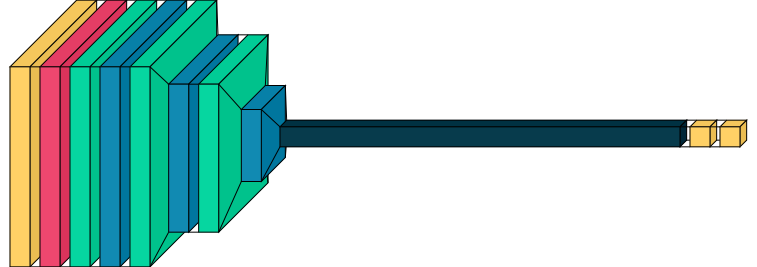

In [21]:
import visualkeras
visualkeras.layered_view(model,max_xy=200)

In [22]:
model.compile(optimizer = 'adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                  

# training

In [24]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
365/365 [==============================] - 182s 494ms/step - loss: 1.9847 - accuracy: 0.1908 - val_loss: 1.9514 - val_accuracy: 0.2080
Epoch 2/10
365/365 [==============================] - 182s 499ms/step - loss: 1.9538 - accuracy: 0.2047 - val_loss: 1.9402 - val_accuracy: 0.2409
Epoch 3/10
365/365 [==============================] - 165s 451ms/step - loss: 1.9397 - accuracy: 0.2146 - val_loss: 1.9276 - val_accuracy: 0.2505
Epoch 4/10
365/365 [==============================] - 169s 462ms/step - loss: 1.9256 - accuracy: 0.2307 - val_loss: 1.9195 - val_accuracy: 0.2450
Epoch 5/10
365/365 [==============================] - 182s 499ms/step - loss: 1.9101 - accuracy: 0.2400 - val_loss: 1.9165 - val_accuracy: 0.2533
Epoch 6/10
365/365 [==============================] - 152s 416ms/step - loss: 1.8967 - accuracy: 0.2482 - val_loss: 1.9037 - val_accuracy: 0.2546
Epoch 7/10
365/365 [==============================] - 163s 447ms/step - loss: 1.8856 - accuracy: 0.2613 - val_loss: 1.9024 -

# Evaluation

In [25]:
def plot_accuracy_loss(history):

    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

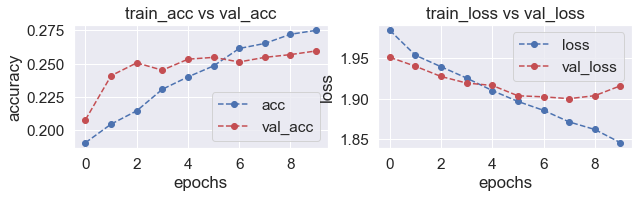

In [26]:
plot_accuracy_loss(history)